An important part of building AI systems is taking the time to understand your data and formatting it for the algorithms. This is often called *preprocessing*. In notebook 1, we began to analyze and understand the data. In this notebook we will do so in a more methodical way.

In [84]:
import pandas as pd
import numpy as np

In [2]:
dat = pd.read_csv("./compas-scores-two-years.csv", index_col=0)
n, p = dat.shape

Preprocessing steps may involve 1) dropping rows that do not meet our inclusion criteria, 2) dropping columns that are not useful for our task, or 3) changing the representation of columns so that our algorithms can handle the data. Let's first consider (1). We should be suspicious of cases where the number of days between arrest date and charge date, *days_b_screening_arrest*, is more than 30. How many of these cases are there?

In [14]:
dat[(dat.days_b_screening_arrest < -30) | (dat.days_b_screening_arrest > 30)].shape[0]

735

There is likely a data quality issue for most of these cases. Therefore we will drop these rows

In [15]:
dat = dat[(dat.days_b_screening_arrest >= -30) & (dat.days_b_screening_arrest <= 30)]

In [23]:
dat.shape

(6172, 52)

Missing data is a common problem when using real-world data. How common is missing data for COMPASS?

In [47]:
dat.isnull().sum()

name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest       0
c_jail_in                     0
c_jail_out                    0
c_case_number                 0
c_offense_date              784
c_arrest_date              5388
c_days_from_compas            0
c_charge_degree               0
c_charge_desc                 5
is_recid                      0
r_case_number              3182
r_charge_degree            3182
r_days_from_arrest         4175
r_offense_date             3182
r_charge_desc              3228
r_jail_in                  4175
r_jail_out                 4175
violent_

This show that all rows have age but 3182 rows are missing r_charge_degree. Sometimes one would drop rows with missing values or impute (fill them in) by using the column average. Before we try either approach, let's first eliminate columns that are not useful as predictors in our model 

Let's consider (2): which columns do we want to include as predictors in our model? Some features, like name or arrest date, are not useful for our task; we should drop these. However, we may later be interested in using these columns for visualizations or analyses: for instance we could ask how risk scores have changed over time as a function of COMPAS screening date. So let's leave *dat* as a dataframe that contains all our information and we'll create a new variable *X* that has the columns we want to use in our model.

The columns that may be informative in predicting who will recommit a crime are the following columns:
- Severity of the current crime: *c_charge_degree*
- history of crime: *priors_count*, *juv_fel_count*, *juv_misd_count*, *juv_other_count*
- demographic information: *age*, *race*, *sex*, 

In [118]:
X = dat[['c_charge_degree', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'age', 'race', 'sex']]

**TODO** Create the outcome variable Y.

**TODO** Now let's check again whether any of our rows have missing values. <span style="color:red">ADD</span>

Now let's consider (3): the representation of each column. What is the type of each variable?

In [119]:
X.dtypes

c_charge_degree    object
priors_count        int64
juv_fel_count       int64
juv_misd_count      int64
juv_other_count     int64
age                 int64
race               object
sex                object
dtype: object

*object* is the pandas data type (dtype) for *string* which is a string of text. Our machine learning algorithms however expect all variables to be numeric. We will need to convert the *object* dtypes to numeric (like *int64*). The most straightforward way to do this is to convert each column to multipe *dummy* columns. 

**TODO** Let's see how many values each object column has and how many occurences of each value there are in the data.

In [70]:
X.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [120]:
X = pd.get_dummies(X)

It may cause problems to have a column with mostly zeros, so to avoid that, let's group 'Asian' and 'Native American' into 'Other'.

In [121]:
X['race_Other'] = X['race_Other'] + X['race_Asian'] + X['race_Native American']
X = X.drop(['race_Asian', 'race_Native American'], axis=1)

Save this pandas dataframe to a CSV for future use. 

In [122]:
X.to_csv("X_pandas.csv")

Convert it to a numpy matrix, which is required for the algorithms. Save dat, X, Y to csv for future use.

In [94]:
X = X.values
Y = Y.values

In [114]:
np.savetxt('X.csv', X)
np.savetxt('y.csv', Y)
dat.to_csv("dat.csv")

In [111]:
X.dtype

dtype('int64')

In this notebook we will train a classifier to predict recidivism. We will analyze how these classifiers perform in terms of accuracy and fairness metrics.

In [12]:
import pickle

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline 

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
X = np.loadtxt("X.csv")
y = np.loadtxt("y.csv")
X_pandas = pd.read_csv("X_pandas.csv")

In [3]:
#set random seed for reproducibility
seed = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)

Let's first train a logistic regression classifier.

In [17]:
logreg = LogisticRegression(C=100000, max_iter=10000, solver = "lbfgs")
logreg.fit(X_train,y_train)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
print("The accuracy is {0:.4f}".format(logreg.score(X_test, y_test)))

The accuracy is 0.6914


Save the model for future use using Python's object serialization package *pickle*. 

In [15]:
pickle.dump(logreg, open("logreg.p", "wb"))

Let's create a vector of predicted labels. Each predicted label is either 0 (if the algorithm thinks the person will not recommit a crime) or 1 (if the algorithm thinks the person will recommit a crime). We can imagine a decision-making process where people who get a predicted label = 1 are denied pre-trial release and peopple who get a predicted label = 0 are released pre-trial.

In [6]:
y_pred = logreg.predict(X_test)

In [7]:
y_pred_train = logreg.predict(X_train)

Let's save two files: 1) for training data and 2) for test data. Each file should contain the features (X), true label, and predictions. 

In [19]:
train = np.hstack((X_train, np.expand_dims(y_train, axis=1), np.expand_dims(y_pred_train, axis=1)))
test = np.hstack((X_test, np.expand_dims(y_test, axis=1), np.expand_dims(y_pred, axis=1)))
np.savetxt('train.csv', train)
np.savetxt('test.csv', test)

We are interested in analyzing how are algorithms assigns decision based on attributes like race or gender since we want to analyze whether the algorithm is unfair.  

Create a mapping to find the column location of each variable. This is needed since NumPy doesn't maintain the column labels as strings (only as numbers). 

In [8]:
feat_map = list(X_pandas.columns)[1:]

Create boolean vectors indicating membership in each race or gender group. 

**TODO** Finish for race_Caucasian, race_Hispanic, and race_Other.

In [9]:
males = X_test[:,feat_map.index('sex_Male')] == 1
afr_am = X_test[:,feat_map.index('race_African-American')] == 1

# Discrimination

If we are going to let an algorithm make an important decision like who gets pre-trial release, we want to make sure the algorithm is accurate and also free from discrimination. But what does discrimination mean especially in the case of an algorithm? How might you define discrimination? Can you give some examples?

Discrimination is typically tied to a *protected attribute* such as race or gender i.e. we argue that there is discrimination on the basis of the protected attribbute. 

Two common definitions of discrimination are **disparate impact** and **disparate treatment**. Disparate *treatment* refers to a process that treats individuals differently based on a demographic attribute. For instance, if a school had a policy that admitted men with a GPA of 3.0 or higher but only admitted women with a GPA of 3.5 or higher, this would be disparate treatment. This explicit notion of discrimination is commonly what people think of as discrimination.

But there's another form of discrimination. Disparate *impact* refers to implicit discrimination, where a seemingly neutral policy leads to disparate outcomes in demographic groups. For instance, if a school had a policy that admitted football players with a GPA of 2.5 or higher but only admitted non-football players with a GPA of 3.5 or higher, then this would be disparate impact. The policy doesn't explicitly use the protected attribute gender, but the policy has the effect of allowing in more men with lower GPA's than women.

What would disparate impact and disparate treatment look like in the case of our pre-trial release algorithm? Can you give examples of policies that would be described as having disparate impact or disparate treatment? Do you think one is more problematic than the other?

# Fairness

Many people argue that a process is fair when it is free of discrimination, and above we considered some definitions of discrimination. We can also directly define fairness. 

## Demographic parity

Demographic parity is a fairness concept that requires that the probability of an outcome be the same for two demographic groups. As an example, consider an algorithm determining loan approvals and consider that we are concerned about gender discrimination. The algorithm would not satisfy demographic parity if the probability of loan approval for women is 0.3 but the probability of loan approval for men is 0.8. 

Is it possible to have demographic parity and disparate impact? What about demographic parity and disparate treatment?

Does our logistic regression classifier satisfy demographic parity with respect to race or gender? 
**TODO** Compute the means for the other race groups and gender groups. Compare the differences. How large of a difference do you think we should accept under the notion of demographic parity?

In [10]:
afr_am_mean = y_pred[afr_am].mean()
print("Logistic regression denies pre-trial release to {0:.1f}% of African-Americans".format(afr_am_mean*100))

Logistic regression denies pre-trial release to 51.6% of African-Americans


## Equalized Odds / Equal False Positive and True Positive Rates

One might argue that it is fair that women are released more often than men if in fact women are less likely to recommit a crime. Then, one could take into account the *true* label in our fairness metrics. We could compare the probability that a woman who did not recidivate would be detained to the probability that a man who did not recidivate would be detained. These quantities are known as the false positive rates.

**TODO** Compute the false positive rate for men and compare to the false positive rate for women.

In [11]:
fem_fpr = y_pred[(X_test[:,feat_map.index('sex_Female')] == 1) & (y_test==0)].mean()

We should also consider the true positive rate: the probability that a person who will recidivate would be detained. 

**TODO** Compute the false negative rates for men and women. 

**Equalized odds** The fairness goal of equalized odds requires that the true positive and false positive rates be the same for our protected attributes. Why do (or don't) you think this makes sense as a notion of fairness?

**TODO** Repeat the equalized odds analysis for race. Does our logistic regression classifier satisfy equalized odds?

## Calibration

We will consider another metric that is a function of the predicted probabilities (as opposed to the predicted labels as we have considered so far). Our model is well-calibrated if the average recidivism rate for a group of people who get a predicted probability of x% is x%. We can plot a calibration curve to analyze this. The predicted probabilities range from 0 to 1, and we can split this up into ten bins: 0 to 0.1, 0.1 to 0.2, 0.2 to 0.3, and so on. On the x-axis, we plot the average of the bin (0.05, 0.15, etc) and on the y-axis we plot the average observed outcome for people who received a predicted probability in that bin.

Note the people sometimes use *score* to refer to predicted probability.


Get vector of scores

In [156]:
y_score = logreg.predict_proba(X_test)[:,1]

Assign each row to a bin

In [176]:
y_score_bins = np.where(y_score <= 0.1, 1, \
                        np.where(y_score <= 0.2, 2,\
                                 np.where(y_score <= 0.3, 3, \
                                          np.where(y_score <= 0.4, 4, \
                                                   np.where(y_score <= 0.5, 5, \
                                                            np.where(y_score <= 0.6, 6, \
                                                                    np.where(y_score <= 0.7, 7, \
                                                                              np.where(y_score <= 0.8, 8, \
                                                                                       np.where(y_score <= 0.9, 9, 10)))))))))

Compute average label outcome for each bin

In [186]:
avg_outcome = []
for b in range(1,11):
    avg = y_test[y_score_bins == b].mean()
    avg_outcome.append(avg)
    

In [137]:
avg_score = [x * 0.01 for x in range(5, 100, 10)]

Plot calibration curve: avg_score against avg_outcome. I plot a solid reference line. A better calibration model will more closely track the reference y=x line. **TODO** Why is the y=x line our reference? How well is the model calibrated? Why do you think the first point is the farthest from the reference line?

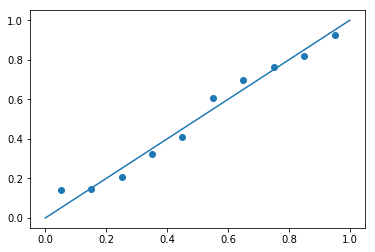

In [190]:
plt.scatter(avg_score, avg_outcome)
plt.plot([0,1], [0,1])

**TODO** Compute three calibration curves: one for each race. Is the model well-calibrated by race? It may be easiest to assess this if you plot all curves on one plot.

Many researchers work on developing fair classifiers. In this notebook we will train some of these methods and analyze how they perform. 

How might you try to make the classifier we built last time more fair? Would you try to change the data or maybe adjust the predictions?

# Fairness Methods
 
 Methods for achieving algorithmic fairness fall into one of three categories:
 - Pre-processing
 - In-processing
 - Post-processing
 
 ## Pre-processing
 
 Pre-processing methods change the data in order to encourage the algorithm to be more fair. For instance we saw that African-Americans had a higher base rate of recidivism than Caucasians. Maybe if we changed the data so that the base rates looked equal (by for instance reweighing the training data), then the algorithm would learn a more fair classification. 
 
 Pre-processing is method agnostic, but it makes no guarantee about how fair the resulting algorithm will be.
 
 ## In-processing
 
 In-processing methods change the actual learning procedure for the model. Most models are learned via an optimization; in-processing methods often constrain that optimization to a *fair* subspace.
 
 In-processing methods are not method agnostic, so they do not generalize well, but you can get fairness guarantees.
 
 ## Post-processing
 
 Post-processing methods take the predictions of any algorithm and adjust them to be more fair. For instance if our algorithm releases 50% of Caucasians but only 30% of African-Americans, then a most processing method could try to achieve demographic parity by randomly releasing 30% of African-Americans who otherwise would have been detained. How would this achieve demographic parity? 

**Your answer**:

As usual we will import pandas and numpy. We also need to import an optimization package cvxpy. And we will import the fair methods from folders in this directory.

In [4]:
import pandas as pd
import numpy as np
import cvxpy as cvx
from equalized_odds_and_calibration.eq_odds import Model

In [181]:
train = np.loadtxt("train.csv")
test = np.loadtxt("test.csv")
X_pandas = pd.read_csv("X_pandas.csv")
feat_map = list(X_pandas.columns)[1:]
feat_map.append("label")
feat_map.append("prediction")
X_train = train[:,:-2]
y_train = train[:,-2]
X_test = test[:, :-2]
y_test = test[:,-2]

# Reweighing to balance base rates

First we will experiment with a pre-processing method that reweighs our training data to balance the base rate. In our first notebook we calculated the base rates and saw they were different. Now that we have partitioned the data into training and test sets, let's recompute the base rates on the test and train partitions. They should be able the same as before but may be a little different based on the randomization.

In [183]:
recid_rate_cauc = y_train[train[:,feat_map.index('race_Caucasian')]==1].mean()
print("The recidivism base rate for Caucasian defendants is {0:.3f}.".format(recid_rate_cauc))
recid_rate_afr_am = y_train[train[:,feat_map.index('race_African-American')]==1].mean()
print("The recidivism base rate for African-American defendants is {0:.3f}.".format(recid_rate_afr_am))

The recidivism base rate for Caucasian defendants is 0.400.
The recidivism base rate for African-American defendants is 0.518.


In [184]:
perc_afr_am = train[:, feat_map.index('race_African-American')].mean()
perc_cauc = train[:, feat_map.index('race_Caucasian')].mean()
recid_rate_all = y_train.mean()

afr_am_pos_dummy = np.logical_and(train[:,feat_map.index('race_African-American')] ==1,\
                 y_train ==1)

afr_am_neg_dummy = np.logical_and(train[:,feat_map.index('race_African-American')] ==1,\
                 y_train ==0)

cauc_pos_dummy = np.logical_and(train[:,feat_map.index('race_Caucasian')] ==1,\
                 y_train ==1)

cauc_neg_dummy = np.logical_and(train[:,feat_map.index('race_Caucasian')] ==1,\
                 y_train ==0)

w_afr_am_pos = perc_afr_am * recid_rate_all \
/ np.logical_and(train[:,feat_map.index('race_African-American')] ==1,\
                 train[:,-2] ==1,).mean()

w_afr_am_neg = perc_afr_am * (1-recid_rate_all) \
/ np.logical_and(train[:,feat_map.index('race_African-American')] ==1,\
                 train[:,-2] ==0,).mean()

w_cauc_pos = perc_cauc * recid_rate_all \
/ np.logical_and(train[:,feat_map.index('race_Caucasian')] ==1,\
                 train[:,-2] ==1,).mean()

w_cauc_neg = perc_cauc * (1-recid_rate_all) \
/ np.logical_and(train[:,feat_map.index('race_Caucasian')] ==1,\
                 train[:,-2] ==0,).mean()

w = w_cauc_neg * np.logical_and(train[:,feat_map.index('race_Caucasian')] ==1,\
                 train[:,-2] ==0,) + \
w_cauc_pos * np.logical_and(train[:,feat_map.index('race_Caucasian')] ==1,\
                 train[:,-2] ==1,) + \
w_afr_am_neg * np.logical_and(train[:,feat_map.index('race_African-American')] ==1,\
                 train[:,-2] ==0,) + \
w_afr_am_pos * np.logical_and(train[:,feat_map.index('race_African-American')] ==1,\
                 train[:,-2] ==1,)

Calculate reweighed base rates.

In [185]:
afr_am_rate_weighed = w[afr_am_pos_dummy].sum()/ \
w[train[:,feat_map.index('race_African-American')]==1].sum()

cauc_rate_weighed = w[cauc_pos_dummy].sum()/ \
w[train[:,feat_map.index('race_Caucasian')]==1].sum()

In [186]:
cauc_rate_weighed

0.4574669187145558

In [187]:
afr_am_rate_weighed

0.4574669187145557

Now use the weights to learn a new logistic regression model

In [171]:
logreg_reweigh = LogisticRegression(C=100000, max_iter=10000, solver = "lbfgs")
logreg_reweigh.fit(X_train,Y, w)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Can you compute the accuracy and the race-specific false positive and false negative rates (like we did in the last notebook)? *Hint* the FPR for African-Americans is given as an example below

In [176]:
y_pred = logreg_reweigh.predict(test[:, :-2])
y_lab = y_pred.round()
fpr_afr_am_reweigh = y_lab[np.logical_and(test[:, feat_map.index('race_African-American')]==1, \
                                          test[:, -2] == 0)].mean()
print("FPR for African-American after reweighing is {0:.4f}".format(fpr_afr_am_reweigh))

FPR for African-American after reweighing is 0.1786


Does reweighing help achieve equalized odds? Why or why not? 

# Post-processing for Equalized Odds

We will explore a method developed by Moritz Hardt et al (https://arxiv.org/pdf/1610.02413.pdf) that uses post-processing techniques to achieve equalized odds. 

Their methods require a Model data structure that takes two inputs: 1) a matrix of the algorithm predictions and 2) a matrix of the true labels. We have to create such a Model object for each demographic group.

In [11]:
feat_map

['priors_count',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'age',
 'c_charge_degree_F',
 'c_charge_degree_M',
 'race_African-American',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'sex_Female',
 'sex_Male',
 'label',
 'prediction']

In [20]:
train.shape

(3703, 15)

In [22]:
afr_am_train = train[train[:,feat_map.index("race_African-American")] == 1]
cauc_train = train[train[:,feat_map.index("race_Caucasian")] == 1]
afr_am_test = test[test[:,feat_map.index("race_African-American")] == 1]
cauc_test = test[test[:,feat_map.index("race_Caucasian")] == 1]

In [10]:
feat_map.index("prediction")

14

In [36]:
model_afr_am_train = Model(afr_am_train[:, feat_map.index("prediction")], afr_am_train[:, feat_map.index("label")])
model_cauc_train = Model(cauc_train[:, feat_map.index("prediction")], cauc_train[:, feat_map.index("label")])
model_afr_am_test = Model(afr_am_test[:, feat_map.index("prediction")], afr_am_test[:, feat_map.index("label")])
model_cauc_test = Model(cauc_test[:, feat_map.index("prediction")], cauc_test[:, feat_map.index("label")])

To check that we have done this properly, we can print the models. This shows us the accuracy, FPR, FNR, base rate and mean prediction.

In [25]:
model_afr_am_train

Accuracy:	0.685
F.P. cost:	0.309
F.N. cost:	0.321
Base rate:	0.518
Avg. score:	0.501

In [26]:
model_cauc_train

Accuracy:	0.665
F.P. cost:	0.152
F.N. cost:	0.610
Base rate:	0.400
Avg. score:	0.247

Now let's call the method for post-processing. This method gives us mixing rates that tell us how to randomly resample predicted labels to equalize false positive rates and false negative rates

In [31]:
_, _, mixing_rates = Model.eq_odds(model_afr_am_train, model_cauc_train)

Now we can correct the predictions using these mixing rates

In [32]:
model_afr_am_train_corrected, model_cauc_train_corrected = Model.eq_odds(model_afr_am_train, model_cauc_train, mixing_rates)

In [33]:
model_afr_am_train_corrected

Accuracy:	0.612
F.P. cost:	0.185
F.N. cost:	0.577
Base rate:	0.518
Avg. score:	0.308

In [34]:
model_cauc_train_corrected

Accuracy:	0.649
F.P. cost:	0.193
F.N. cost:	0.587
Base rate:	0.400
Avg. score:	0.281

Did this achieve equalized odds? 

**Your answer**

We should evaluate how the mixing performs on the test partition. Why do we need to do this? Should we get new mixing rates on the test partition or use the mixing rates learned from the train partition?

**Your answer**

In [37]:
model_afr_am_test_corrected, model_cauc_test_corrected = Model.eq_odds(model_afr_am_test, model_cauc_test, mixing_rates)

In [38]:
model_cauc_test_corrected

Accuracy:	0.672
F.P. cost:	0.178
F.N. cost:	0.576
Base rate:	0.378
Avg. score:	0.271

In [39]:
model_afr_am_test_corrected

Accuracy:	0.592
F.P. cost:	0.207
F.N. cost:	0.585
Base rate:	0.531
Avg. score:	0.318

In [40]:
model_cauc_test

Accuracy:	0.691
F.P. cost:	0.136
F.N. cost:	0.594
Base rate:	0.378
Avg. score:	0.238

In [41]:
model_afr_am_test

Accuracy:	0.688
F.P. cost:	0.316
F.N. cost:	0.307
Base rate:	0.531
Avg. score:	0.516

What notion of fairness does this method achieve, if any? What is the effect of this method on the accuracy? Do you think we should use this method for our pre-trial bail application?